In [5]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.plotting import plot_decision_regions
import pickle
from sklearn.externals import joblib # saving modelsa
%matplotlib inline
# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Class balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline, make_pipeline

#Modeling
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Yellowbrick visuals-- used for model selection + metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import FeatureImportances

/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [6]:
# To load pickle back in
with open('df_cleaned.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [7]:
df

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Response,Age,total_accepted_offers,Education_Graduation,Education_HigherEd,Marital_Status_OnceMarried,Marital_Status_Single,Marital_Status_Together,CustomerLength,TotalRevenueFoodItems
0,58138.0,0,0,58,635,88,546,172,88,88,...,1,58,0,1,0,0,1,0,849,1529
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,61,0,1,0,0,1,0,299,21
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,50,0,1,0,0,0,1,498,734
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,31,0,1,0,0,0,1,325,48
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,34,0,0,1,0,0,0,347,407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,61223.0,0,1,46,709,43,182,42,118,247,...,0,48,0,1,0,0,0,0,567,1094
2236,64014.0,1,1,56,406,0,30,0,0,8,...,0,69,1,0,1,0,0,1,205,436
2237,56981.0,0,0,91,908,48,217,32,12,24,...,0,34,1,1,0,1,0,0,341,1217
2238,69245.0,0,1,8,428,30,214,80,30,61,...,0,59,0,0,1,0,0,1,342,782


## Looks like wine + meats are top drivers of total food revnue

In [8]:
df['MntWines']/ df['TotalRevenueFoodItems']

0       0.415304
1       0.523810
2       0.580381
3       0.229167
4       0.425061
          ...   
2235    0.648080
2236    0.931193
2237    0.746097
2238    0.547315
2239    0.556291
Length: 2215, dtype: float64

In [9]:
df2 = df.drop(['Marital_Status_OnceMarried', 'Marital_Status_Single',\
                 'Marital_Status_Together', 'Education_HigherEd', 'Education_Graduation', 'AcceptedCmp3',\
                 'AcceptedCmp4', 'AcceptedCmp5','AcceptedCmp1','AcceptedCmp2' ], axis=1)

In [10]:
#sns.pairplot(df)

In [11]:
#sns.heatmap(df2.corr())

In [12]:
# Obviously total rev is correlated with MntX spend + purchases by location-- surprisingly it is neg (-0.5) corr
# with Number of web visits/mo... There is no dif between 0,1 for this.

# But overall, maybe web traffic is not a driver of these purchases -- so prob not the best place to advertise

df.corr()['TotalRevenueFoodItems']

Income                        0.793020
Kidhome                      -0.566360
Teenhome                     -0.153353
Recency                       0.019020
MntWines                      0.897638
MntFruits                     0.604976
MntMeatProducts               0.851275
MntFishProducts               0.632584
MntSweetProducts              0.601928
MntGoldProds                  0.462367
NumDealsPurchases            -0.073123
NumWebPurchases               0.515950
NumCatalogPurchases           0.775505
NumStorePurchases             0.670213
NumWebVisitsMonth            -0.499069
AcceptedCmp3                  0.044082
AcceptedCmp4                  0.257672
AcceptedCmp5                  0.474927
AcceptedCmp1                  0.382489
AcceptedCmp2                  0.137651
Response                      0.263186
Age                           0.112537
total_accepted_offers         0.459718
Education_Graduation          0.014181
Education_HigherEd            0.028479
Marital_Status_OnceMarrie

In [13]:
df.corr()['Response']

Income                        0.161049
Kidhome                      -0.071940
Teenhome                     -0.161058
Recency                      -0.199981
MntWines                      0.246185
MntFruits                     0.122391
MntMeatProducts               0.237653
MntFishProducts               0.108054
MntSweetProducts              0.116065
MntGoldProds                  0.140232
NumDealsPurchases             0.003617
NumWebPurchases               0.151367
NumCatalogPurchases           0.219830
NumStorePurchases             0.036085
NumWebVisitsMonth            -0.002156
AcceptedCmp3                  0.253966
AcceptedCmp4                  0.180162
AcceptedCmp5                  0.323339
AcceptedCmp1                  0.297312
AcceptedCmp2                  0.169279
Response                      1.000000
Age                          -0.023825
total_accepted_offers         0.427076
Education_Graduation         -0.039482
Education_HigherEd            0.055023
Marital_Status_OnceMarrie

In [14]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Age', 'total_accepted_offers',
       'Education_Graduation', 'Education_HigherEd',
       'Marital_Status_OnceMarried', 'Marital_Status_Single',
       'Marital_Status_Together', 'CustomerLength', 'TotalRevenueFoodItems'],
      dtype='object')

In [15]:
df.NumWebPurchases

0       8
1       1
2       8
3       2
4       5
       ..
2235    9
2236    8
2237    2
2238    6
2239    3
Name: NumWebPurchases, Length: 2215, dtype: int64

# EDA by group so we can answer some questions about behaviors and why it's important to hit more 1s
- 1 buy more food by far
- 1 have less days since last purchase
- 

In [16]:
# Looking at those who bought vs who did not
gb_resp = df.groupby('Response')

In [17]:
gb_resp.corr()['NumStorePurchases']

Response                            
0         Income                        0.636131
          Kidhome                      -0.506412
          Teenhome                      0.078534
          Recency                      -0.013454
          MntWines                      0.689380
          MntFruits                     0.483432
          MntMeatProducts               0.506467
          MntFishProducts               0.483023
          MntSweetProducts              0.468642
          MntGoldProds                  0.419020
          NumDealsPurchases             0.095311
          NumWebPurchases               0.536897
          NumCatalogPurchases           0.530489
          NumStorePurchases             1.000000
          NumWebVisitsMonth            -0.427413
          AcceptedCmp3                 -0.065774
          AcceptedCmp4                  0.166929
          AcceptedCmp5                  0.175684
          AcceptedCmp1                  0.158185
          AcceptedCmp2          

# use seaborn and use error bars to see if sig

In [18]:
df.columns

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Response', 'Age', 'total_accepted_offers',
       'Education_Graduation', 'Education_HigherEd',
       'Marital_Status_OnceMarried', 'Marital_Status_Single',
       'Marital_Status_Together', 'CustomerLength', 'TotalRevenueFoodItems'],
      dtype='object')

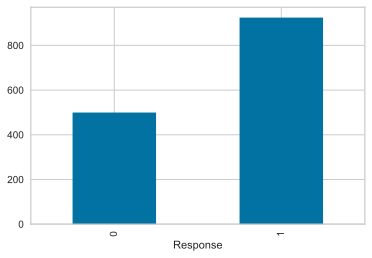

In [19]:
gb_resp['TotalRevenueFoodItems'].mean().plot(kind='bar')

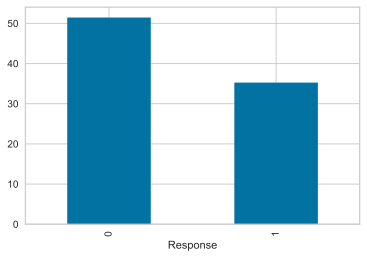

In [20]:
gb_resp['Recency'].mean().plot(kind='bar')

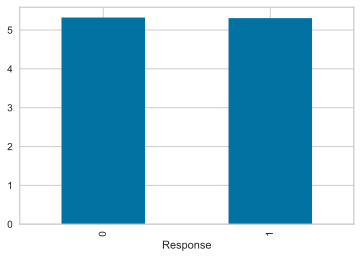

In [21]:
gb_resp['NumWebVisitsMonth'].mean().plot(kind='bar')

# EDA by group for areas of purchase (store, web, catalog)

In [22]:
gb_resp.NumWebVisitsMonth.mean()

Response
0    5.320935
1    5.306306
Name: NumWebVisitsMonth, dtype: float64

In [23]:
gb_resp.NumCatalogPurchases.mean()

Response
0    2.401169
1    4.201201
Name: NumCatalogPurchases, dtype: float64

In [24]:
gb_resp.NumDealsPurchases.mean()

Response
0    2.319872
1    2.339339
Name: NumDealsPurchases, dtype: float64

In [25]:
gb_resp.NumStorePurchases.mean()

Response
0    5.752922
1    6.081081
Name: NumStorePurchases, dtype: float64

In [26]:
gb_resp.NumWebPurchases.mean()

Response
0    3.911265
1    5.072072
Name: NumWebPurchases, dtype: float64

In [27]:
gb_resp.Recency.mean()

Response
0    51.459086
1    35.264264
Name: Recency, dtype: float64

In [28]:
gb_resp.TotalRevenueFoodItems.mean()

Response
0    499.454835
1    924.408408
Name: TotalRevenueFoodItems, dtype: float64

In [29]:
for i in df.columns:
    print(gb_resp[i].mean())

Response
0    50511.913390
1    60209.675676
Name: Income, dtype: float64
Response
0    0.435707
1    0.336336
Name: Kidhome, dtype: float64
Response
0    0.516472
1    0.291291
Name: Teenhome, dtype: float64
Response
0    51.459086
1    35.264264
Name: Recency, dtype: float64
Response
0    270.299150
1    502.615616
Name: MntWines, dtype: float64
Response
0    24.312965
1    37.939940
Name: MntFruits, dtype: float64
Response
0    144.644527
1    293.765766
Name: MntMeatProducts, dtype: float64
Response
0    35.162593
1    51.714715
Name: MntFishProducts, dtype: float64
Response
0    25.035600
1    38.372372
Name: MntSweetProducts, dtype: float64
Response
0    40.923486
1    61.252252
Name: MntGoldProds, dtype: float64
Response
0    2.319872
1    2.339339
Name: NumDealsPurchases, dtype: float64
Response
0    3.911265
1    5.072072
Name: NumWebPurchases, dtype: float64
Response
0    2.401169
1    4.201201
Name: NumCatalogPurchases, dtype: float64
Response
0    5.752922
1    6.081081
Nam

# Make toy data to show stagnant growth


In [32]:
toy_data = pd.DataFrame({"Quarter" : ['Q1 2018', 'Q2 2018', 'Q3 2018', 'Q4 2018', 'Q1 2019', 'Q2 2019','Q3 2019'], 
                     "% Growth" : [6, 4.7, 5.3,3.5,3.1,1,1]})

In [ ]:
sns.set(style='darkgrid',palette='deep', font_scale=1.5)
#sns.color_palette('Blues')
ax = sns.barplot(x="Quarter", y="% Growth", data=toy_data);

fig = ax.figure
fig.set_size_inches(11,9) #width,height
plt.style.use('bmh')
plt.title('Quarterly Revenue Growth')
plt.tight_layout()
plt.savefig('Quarterly_Revenue_Growth');

# KDE tests


In [33]:
sns.set(color_codes=True)

In [39]:
x = df['Recency']
y = df['Response']

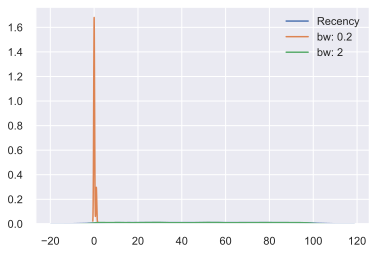

In [42]:
sns.kdeplot(x)
sns.kdeplot(y, bw=.2, label="bw: 0.2")
sns.kdeplot(x, bw=2, label="bw: 2")
plt.legend();